# Projeto realizado realizado por:
Ana Pais da Silva - up201503727

Francisco Carvalho - up201504423

João Calçada - up201703511

In [6]:

import pandas as pd
import numpy as np

import matplotlib.image as pltimg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV, StratifiedShuffleSplit, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.svm import SVC



train = pd.read_csv('../input/c/titanic/train.csv', sep=",",index_col="PassengerId")
test=pd.read_csv('../input/c/titanic/test.csv', sep=",",index_col="PassengerId")


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python

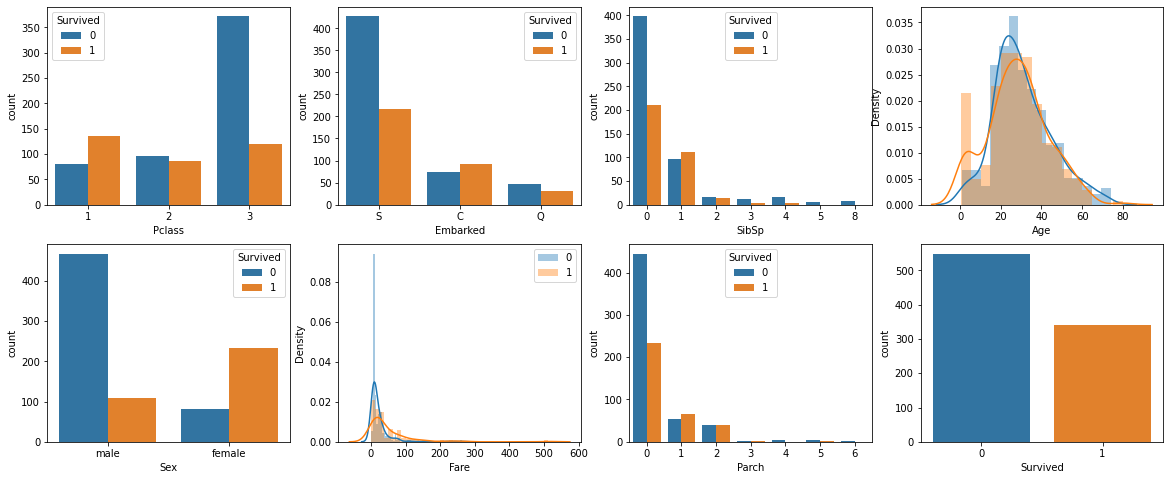

In [7]:
fig, axes = plt.subplots(2, 4,figsize=(20,8))
y_train = train[['Survived']]
x_train = train.drop("Survived",1)
#create boxplot in each subplot

sns.countplot(x='Pclass',hue='Survived', data=train,ax=axes[0,0])

sns.countplot(x='Sex',hue='Survived', data=train,ax=axes[1,0])

sns.countplot(x="Embarked", hue="Survived", data=train,ax=axes[0,1])

sns.countplot(x='SibSp',hue='Survived', data=train,ax=axes[0,2])

sns.countplot(x='Parch',hue='Survived', data=train,ax=axes[1,2])

sns.distplot(train[train['Survived']==0]['Age'], label ='Not survived',ax=axes[0,3])
sns.distplot(train[train['Survived']==1]['Age'], label ='Survived',ax=axes[0,3])

sns.countplot(x='Survived', data=y_train,ax=axes[1,3])

sns.distplot(train[train['Survived'] == 0]['Fare'], label=0,ax=axes[1,1])
sns.distplot(train[train['Survived'] == 1]['Fare'], label=1,ax=axes[1,1])
axes[1,1].legend(loc='upper right')

plt.show()



## Analisando os gráficos:
- Tickets de 3ª class morreram mais;
- Morreram mais homens que mulheres;
- Pessoas sem irmãos têm menor taxa de sobrevivência;
- Pessoas com pais ou filhos tiveram menor probabilidade de morrer;
- Pessoas a embarcar de Southampton registaram mais mortalidade;
- Pessoas com bilhetes mais caros têm mais chances de sobreviver, nota-se pela distribuição mais achatada da linha relativa aos sobreviventes (laranja), no gráfico da Fare.
- Relativamente à idade nota-se que as crianças tinham mais probabilidades de sobreviver.

In [ ]:
train.info()
print(train.isnull().sum())


### À partida destaca-se logo a falta de alguns parâmetros nas colunas relativas à idade dos passageiros (Age), à cabine (Cabin) e ao porto de embarque (Embarked).  

### Assim decidimos retirar o parâmetro Cabin devido à escassez de entradas por ele apresentado. Relativamente à Age fomos procurar preencher da melhor maneira as entradas em falta, através de análise mais detalhada da data:

# 1a) Determinação das idades em falta.


### Após análise dos dados, reparámos que, o nome das pessoas nos davam informação relativamente aos títulos das mesmas. Recorrendo a ajudas dadas no kaddle, onde nos diziam o mapeamento destes títulos decidimos destacar pessoas com 6 títulos 'Mr','Miss','Mrs','Master','Rev','Dr'. 

In [ ]:

combine = train.append(test)
combine=combine.drop(['Cabin'],1)
print(combine[combine['Fare'].isnull()])
print(combine[combine['Embarked'].isnull()])


#combine.drop(['PassengerId'], axis=1, inplace=True)

for name_string in combine['Name']:
    combine['Title']=combine['Name'].str.extract('([A-Za-z]+)\.',expand=True)

#replacing the rare title with more common one.
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}

combine.replace({'Title': mapping}, inplace=True)


titles=['Mr','Miss','Mrs','Master','Rev','Dr']




In [ ]:
combine.info()
print(combine.isnull().sum())

### Fomos procurar relações entre os parâmetros de idade, classe e títulos dos passageiros, pois pareceu-nos as entradas mais relevantes para determinar as idades.

In [ ]:
#boxplot idades em função do título
fig = plt.subplots(figsize=(20,8))
sns.boxplot(x = 'Title', y = 'Age', data=combine, hue='Pclass')
plt.show()

### Deste gráfico retira-se, que o título Master é associado a crianças, de facto, fomos pesquisar e concluímos  que, este título é dado aos primogénitos. Observa-se também, um aumento da idade com a classe. Os títulos Rev e Dr apenas têm 1ª e 2ª classes.

### Assim, fomos substituir as idades pelas medianas da idade de cada distribuição, por classe e título, que já seria uma abordagem mais aproximada do que se déssemos a média das idades sem ser descriminada em grupos.

In [ ]:
# substituir idades pelas medianas
for title in titles:
    dtit=combine[combine['Title']==title]
    for i in range(3):
        dtitpclass=dtit[dtit['Pclass']==i+1]['Age']

        age_to_impute = np.mean(dtitpclass)
        
        combine.loc[(combine['Age'].isnull()) & (combine['Title'] == title) & (combine['Pclass']==i+1), 'Age'] = age_to_impute
      
print(combine.isnull().sum()) 


In [ ]:

combine.loc[(combine['Embarked'].isnull()),'Embarked']='S'
combine.loc[(combine['Fare'].isnull()),'Fare']=np.mean(combine[combine['Pclass']==3]['Pclass'])
print(combine.isnull().sum())


## Temos assim os dados sem valores NaN, isto porque os 418 do survived correspondem aos valores de test.Temos agora de transformar todos os valores não numéricos em valores numéricos para podermos aplicá-los nos modelos.

In [ ]:

combine['Embarked_S']=(combine['Embarked']=='S').astype(int)
combine['Embarked_C']=(combine['Embarked']=='C').astype(int)
combine['Embarked_Q']=(combine['Embarked']=='Q').astype(int)

combine.drop("Embarked",1,inplace=True)


combine['Sex'] = combine.Sex.apply(lambda x: 0 if x == "female" else 1)
def condition(x):
  if x=='Mr':
    return 0 
  elif x=='Mrs':
    return 1 
  elif x=='Master': 
    return 2 
  elif x=='Miss':
    return 3 
  else:
    return 4
combine['Title']= combine.Sex.apply(condition)

## Observando os gráficos dos parâmetros Parch e SibSp ficámos com impresão, que pessoas a viajar sozinhas tinham menor probabilidade de sobreviver. Assim, dado estes parâmetros serem relativos aos membros de família decidimos juntá-los criando um novo, FamilySize.


In [ ]:

plt.subplots(1, 1,figsize=(12,7))
combine['FamilySize']= combine['SibSp'] + combine['Parch'] + 1
train['FamilySize']= train['SibSp'] + train['Parch'] + 1
sns.countplot(x='FamilySize',data=train,hue='Survived')
plt.show()


## Visto haver uma diferença clara entre sobreviver com familySize de {2,3 e 4} e as outras decidimos separar estes casos dos outros. Assim, também evitamos overfitting pois reduzimos o número de variáveis.

In [ ]:

combine['FamilySize'] = combine.FamilySize.apply(lambda x: 1 if x in [2,3,4]  else 0)
print(sum(combine['FamilySize']==1))
print(combine['FamilySize'])

# Conected family
## Outra análise feita, foi se pessoas de famílias onde houve sobreviventes, teriam mais probabilidade de sobreviver, isto porque, imaginámos que, estes grupos se tenham ajudado a chegar aos barcos de salvamento e não só, nesse ponto teriam prioridade como um grupo. Para determinarmos as famílias, recorremos ao sobrenome e aos Tickets. 

## A introdução da variável Ticket neste caso ajuda-nos a descartar pessoas com sobrenomes diferentes.

In [ ]:
#Coluna só com sobrenomes
combine['Surname'] = combine.Name.str.extract(r'([A-Za-z]+),', expand=False)
#Coluna de strings de tickets
combine['TixPref'] = combine.Ticket.str.extract(r'(.*\d)', expand=False)
#Coluna de junção entre Tickets e sobrenomes
combine['SurTix'] = combine['Surname'] + combine['TixPref']
#Se houver duplicados essas entradas são True 
combine['IsFamily'] = combine.SurTix.duplicated(keep=False)*1

sns.countplot(x=combine['IsFamily'],data=combine)
plt.show()

In [ ]:
combine['Child'] = combine.Age.map(lambda x: 1 if x <=16 else 0)
FamilyWithChild = combine[(combine['IsFamily']==1)&(combine['Child']==1)]['SurTix'].unique()

combine['FamilyId'] = 0
x = 1
for tix in FamilyWithChild:
  combine.loc[combine['SurTix']==tix, ['FamilyId']] = x
  x += 1


In [ ]:

combine['SurvivedDemo'] = combine['Survived'].fillna(9)


plt.rcParams["figure.figsize"] = [15,5 ]
plt.rcParams["figure.autolayout"] = True

pd.crosstab(combine['FamilyId'], combine['SurvivedDemo']).drop([0]).plot(kind='bar', stacked=True, color=['black','g','grey'])

plt.show()

In [ ]:
combine['ConnectedSurvival'] = 0.5 
Survived_by_FamilyId = combine.groupby('FamilyId').Survived.sum()

for i in range(1, len(FamilyWithChild)+1):
  if Survived_by_FamilyId[i] >= 1:
    combine.loc[combine['FamilyId']==i, ['ConnectedSurvival']] = 1
  elif Survived_by_FamilyId[i] == 0:
    combine.loc[combine['FamilyId']==i, ['ConnectedSurvival']] = 0

train = combine.loc[0:891,]

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

sns.barplot(x='ConnectedSurvival', y='Survived', data=train)
plt.title('train data conexão entre famílias')

plt.show()

## Vê-se de imediato que famílias onde sobreviveu um dos elementos teem maior probabilidade de sobreviver mais membros.

In [ ]:
combine.columns


In [ ]:
dropers=['Name', 'SibSp', 'Parch', 'Ticket','Surname', 'TixPref', 'SurTix', 'IsFamily', 'Child',
       'SurvivedDemo','Title','FamilyId']

for i in dropers:
  combine=combine.drop(i,1)


In [ ]:
combine.info()

In [ ]:
train = combine.loc[0:891,]
test= combine.loc[892:,]
test=test.drop("Survived",1)

x=train.drop("Survived",1)
y=train["Survived"]

print(len(train),len(test))
train_1 = train.loc[0:int(891*0.7),]
train_2 = train.loc[int(891*0.7):,]

x1 = train_1.drop("Survived",1)
y1 = train_1["Survived"]

x2 = train_2.drop("Survived",1)
y2 = train_2["Survived"]


In [ ]:
def accgen(predict):
    return sum(predict==y2)/len(y2)

# 2 Implementação de modelos

In [ ]:
pip install xgboost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
clfs=[SVC(),DecisionTreeClassifier(),RandomForestClassifier(),KNeighborsClassifier(),LogisticRegression(max_iter = 2000),
      XGBClassifier(random_state =1,eval_metric='logloss',use_label_encoder=False)]

acc=np.zeros(len(clfs))
acc2=np.zeros(len(clfs))

for i in range(len(clfs)):
    clf = clfs[i]
    clf.fit(x1,y1)
    prediction = clf.predict(x2)
    acc[i]=accgen(prediction)

    cv = cross_val_score(clf,x,y,cv=5)
    acc2[i]=100*cv.mean()
print(acc2)


In [ ]:
#plot
col=['SVC','DTree','RdForest','KNeighbors','LogisticReg','Xgboost']


plotdata=pd.DataFrame(acc2.reshape(-1,1).T,columns=col)
print(plotdata)
sns.barplot(data=plotdata)

plt.xlabel('Modelused')
plt.ylabel('Accuracy')
plt.title("Models accuracy")
plt.show()

# b) Otimização randomforest

In [ ]:
rf = RandomForestClassifier()

params = {'n_estimators': [50,100],
          'max_depth': [8,10,12],
          'criterion':['gini','entropy'],
          'min_samples_leaf' : [3, 5],
          'max_features':['auto','sqrt'],
          'min_samples_split': [5, 10, 15],
          'max_leaf_nodes':[10,15],
          'random_state':[0,1]}

clf = GridSearchCV(estimator=rf ,param_grid=params, cv=10, n_jobs=-1)

In [ ]:
clf.fit(x, y)
print(clf.best_estimator_)
print(clf.best_score_)



#####

In [ ]:


bmrf=clf.best_estimator_

best_rf = bmrf.fit(x1, y1)

importance = pd.Series(bmrf.feature_importances_,index=x1.columns).sort_values(ascending=False)

sns.barplot(x=importance, y=importance.index)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title("Important Features")
plt.show()

In [ ]:

bmrf.fit(x1, y1)
y_pred = bmrf.predict(x2)

acc3[0]=accgen(y_pred)
print(acc3[0])


In [ ]:
bmrf.fit(x,y)
subpredic=bmrf.predict(test)

In [ ]:

def subconv(ans,passengerbeginnumber,name):
    ans1 = ans.reshape(-1,1)
    passid=np.arange(passengerbeginnumber,passengerbeginnumber+len(ans)).reshape(-1,1)
    ans1=np.block([passid,ans1])
    
    result = pd.DataFrame(ans1,columns=['PassengerId','Survived']).astype(int)
    print(result)
    filename = r'./{}.csv'.format(name)
    result.to_csv(filename,index=False)
    result.to_csv("result.csv",index=False)
    
    print('Saved file: ' + filename)

In [ ]:
subconv(subpredic, 892, 'sub')

# Com este modelo obtivemos uma pontuação de 79,665% na competição

# Otimização Logistic regression

In [ ]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)

In [ ]:
clf_lr.fit(x, y)
print(clf_lr.best_estimator_)
print(clf_lr.best_score_)



In [ ]:

bmlr=clf_lr.best_estimator_
bmlr.fit(x1, y1)
y_pred = bmlr.predict(x2)
acc3[1]=accgen(y_pred)
print(acc3[1])


In [ ]:
bmlr.fit(x,y)
subpredic2=bmlr.predict(test)

In [ ]:
subconv(subpredic2, 892, 'sub2')

## Com este modelo obtivemos uma pontuação de 79,186% na competição.

# Otimização Xgboost

In [ ]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [450,500,550],
    'colsample_bytree': [0.75,0.8,0.85],
    'max_depth': [10],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6, .65],
    'learning_rate':[0.5],
    'gamma':[.5,1,2],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)



In [ ]:
best_clf_xgb = clf_xgb.fit(x,y)
print(clf_xgb.best_estimator_)
print(clf_xgb.best_score_)


In [ ]:

bmlr=clf_xgb.best_estimator_

bmxgb=clf_xgb.best_estimator_
bmxgb.fit(x1, y1)
y_pred = bmxgb.predict(x2)

acc3[2]=accgen(y_pred)
print(acc3[2])


In [ ]:
bmxgb.fit(x,y)
subpredicxbg=bmxgb.predict(test)

In [ ]:
subconv(subpredicxbg, 892, 'subxgb')

# Com este modelo obtivemos uma pontuação de 79,186% na competição.

# Otimização modelo SVC

In [ ]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000],'max_iter':[1000000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000],'max_iter':[1000000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000],'max_iter':[1000000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)



In [ ]:

best_clf_svc = clf_svc.fit(x,y)

print(clf_svc.best_estimator_)
print(clf_svc.best_score_)

In [ ]:

bmlr=clf_svc.best_estimator_

bmsvc=clf_svc.best_estimator_
bmsvc.fit(x1, y1)
y_pred = bmsvc.predict(x2)

acc3[3]=accgen(y_pred)
print(acc3[3])


In [ ]:
bmsvc.fit(x,y)
subpredicsvc=bmsvc.predict(test)

In [ ]:
subconv(subpredicsvc, 892, 'sub3')

## Com este modelo obtivemos uma pontuação de 79,186% na competição.

# Otimização KNeighbors

In [ ]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)


In [ ]:

best_clf_knn = clf_knn.fit(x,y)
print(clf_knn.best_estimator_)
print(clf_knn.best_score_)

In [ ]:


bmlr=clf_knn.best_estimator_

bmknn=clf_knn.best_estimator_
bmknn.fit(x1, y1)
y_pred = bmknn.predict(x2)

acc3[4]=accgen(y_pred)
print(acc3[4])


In [ ]:
bmknn.fit(x,y)
subpredicknn=bmknn.predict(test)

In [ ]:
subconv(subpredicknn, 892, 'subKNN')

# Com este modelo obtivemos uma pontuação de 62,918% na competição.

In [ ]:
col=['RdForest','LogisticReg','Xgboost','SVC','KNeighbors']

plotdata=pd.DataFrame(acc3.reshape(-1,1).T,columns=col)
print(plotdata)
sns.barplot(data=plotdata)

plt.xlabel('Modelused')
plt.ylabel('Accuracy')
plt.title("Models accuracy")
plt.show()

# Modelos combinados

In [ ]:


voting_clf_hard = VotingClassifier(estimators = [('knn',bmknn),('rf',bmrf),('svc',bmsvc)], voting = 'hard') 
voting_clf_soft = VotingClassifier(estimators = [('knn',bmknn),('rf',bmrf),('svc',bmsvc)], voting = 'soft') 
voting_clf_lr = VotingClassifier(estimators = [('rf',bmrf),('svc',bmsvc), ('lr', bmlr)], voting = 'soft') 
voting_clf_all = VotingClassifier(estimators = [('knn',bmknn),('rf',bmrf),('svc',bmsvc), ('xgb', bmxgb),('lr', bmlr)], voting = 'soft')

In [ ]:

cvhard=cross_val_score(voting_clf_hard,x,y,cv=5)
print('voting_clf_hard :',cvhard)
print('voting_clf_hard mean :',cvhard.mean())

cvsoft=cross_val_score(voting_clf_soft,x,y,cv=5)
print('voting_clf_soft :',cvsoft)
print('voting_clf_soft mean :',cvsoft.mean())

cvall=cross_val_score(voting_clf_all,x,y,cv=5)
print('voting_clf_all :',cvall)
print('voting_clf_all mean :',cvall.mean())

cvlr=cross_val_score(voting_clf_lr,x,y,cv=5)
print('voting_clf_xgb :',cvlr)
print('voting_clf_xgb mean :',cvlr.mean())

In [ ]:
voting_clf_hard.fit(x,y)
voting_clf_soft.fit(x,y)
voting_clf_all.fit(x,y)
voting_clf_lr.fit(x,y)


pred_vc_hard = voting_clf_hard.predict(test).astype(int)
pred_rf = best_rf.predict(test).astype(int)
pred_vc_soft =  voting_clf_soft.predict(test).astype(int)
pred_vc_all = voting_clf_all.predict(test).astype(int)
pred_vc_lr = voting_clf_lr.predict(test).astype(int)

In [ ]:
subconv(pred_vc_hard, 892, 'hard')
subconv(pred_vc_soft, 892, 'soft')
subconv(pred_vc_all, 892, 'all')
subconv(pred_vc_lr, 892, 'lr')

# Performance do modelos na competição:
- HARD:77,751
- SOFT:78,947
- Lr:79,904%
### - ALL: 80,382%

In [ ]:
acccomb=[cvhard.mean(),cvsoft.mean(),cvlr.mean(),cvall.mean()]
col=np.array([0,1,2,3,4,5,6,7,8])
model=np.concatenate([col,col])

competition=np.array([0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1])

accfinal=np.concatenate([acc3,acccomb])
accfinalcomp=np.array([0.79665,0.79186,0.79186,0.79186,0.62918,0.77751,0.78947,0.79904,0.80382])

accfim=np.concatenate([accfinal,accfinalcomp])
accfim2=np.block([accfim.reshape(-1,1),competition.reshape(-1,1)])
accfim3=np.block([accfim2,model.reshape(-1,1)])

plotdata=pd.DataFrame(accfim3,columns=['accuracy','competition','model'],dtype=float)
print(plotdata)
sns.barplot(data=plotdata,y='accuracy',x='model',hue='competition')


plt.xlabel('Modelused')
plt.ylabel('Accuracy')
plt.title("Models accuracy")
plt.show()

## Algo que reparámos estar a acontecer em todos os modelos, foi overfitting assim fomos procurar alterar alguns parâmetros das features. Separamos os parâmetros age e fare em bins.

In [ ]:
train['AgeBin_5'] = pd.qcut(train['Age'], 5)
test['AgeBin_5'] = pd.qcut(test['Age'], 5)
sns.barplot(x='AgeBin_5', y='Survived', data=train)
plt.show()

In [ ]:
train['FareBin_5'] = pd.qcut(train['Fare'], 5)
test['FareBin_5'] = pd.qcut(test['Fare'], 5)
sns.barplot(x='FareBin_5', y='Survived', data=train)
plt.show()

In [ ]:


def condbinfare(x):
  if x<= 7.854:
    return 0 
  elif (x>=7.8541 and x<=10.5):
    return 1 
  elif (x>=10.51 and x<=21.679): 
    return 2 
  elif (x>=21.6791 and x<=39.688):
    return 3 
  else:
    return 4

def condbinage(x):
  if x<= 19:
    return 0 
  elif (x>=19.1 and x<=26):
    return 1 
  elif (x>=26.1 and x<=30): 
    return 2 
  elif (x>=30.1 and x<=40.5):
    return 3 
  else:
    return 4

train['FareBin_5']=train.Fare.apply(condbinfare)
test['FareBin_5']=test.Fare.apply(condbinfare)

train['AgeBin_5']=train.Fare.apply(condbinage)
test['AgeBin_5']=test.Fare.apply(condbinage)

In [ ]:
train=train.drop('Fare',1)
test=test.drop('Fare',1)
train=train.drop('Age',1)
test=test.drop('Age',1)


x=train.drop("Survived",1)
y=train["Survived"]

print(len(train),len(test))
train_1 = train.loc[0:int(891*0.7),]
train_2 = train.loc[int(891*0.7):,]

x1 = train_1.drop("Survived",1)
y1 = train_1["Survived"]

x2 = train_2.drop("Survived",1)
y2 = train_2["Survived"]

In [ ]:

cvhard=cross_val_score(voting_clf_hard,x,y,cv=5)
print('voting_clf_hard :',cvhard)
print('voting_clf_hard mean :',cvhard.mean())

cvsoft=cross_val_score(voting_clf_soft,x,y,cv=5)
print('voting_clf_soft :',cvsoft)
print('voting_clf_soft mean :',cvsoft.mean())

cvall=cross_val_score(voting_clf_all,x,y,cv=5)
print('voting_clf_all :',cvall)
print('voting_clf_all mean :',cvall.mean())

cvxgb=cross_val_score(voting_clf_lr,x,y,cv=5)
print('voting_clf_lr :',cvxgb)
print('voting_clf_lr mean :',cvxgb.mean())


In [ ]:
voting_clf_hard.fit(x,y)
voting_clf_soft.fit(x,y)
voting_clf_all.fit(x,y)
voting_clf_lr.fit(x,y)


pred_vc_hard = voting_clf_hard.predict(test).astype(int)
pred_rf = best_rf.predict(test).astype(int)
pred_vc_soft =  voting_clf_soft.predict(test).astype(int)
pred_vc_all = voting_clf_all.predict(test).astype(int)
pred_vc_xgb = voting_clf_lr.predict(test).astype(int)

In [ ]:
subconv(pred_vc_hard, 892, 'hard')
subconv(pred_vc_soft, 892, 'soft')
subconv(pred_vc_all, 892, 'all')
subconv(pred_vc_xgb, 892, 'lr')

# Desta maneira melhorámos ligeiramente os resultados da competição embora tenhámos diminuído o score local. Os resultados na competição foram:
- HARD:79,665%
- SOFT:79,904%
- ALL:80,143%
### - XGB: 80,622%